In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import time

import numpy as np
from abcpy.core import *
from abcpy.distributions import *
from distributed import Client
from dask.dot import dot_graph
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
client = Client()

In [3]:
def MA1(n, t1, prng=None, latents=None):
    if latents is None:
        if prng is None:
            prng = np.random.RandomState()
        latents = prng.randn(n+1) # i.i.d. sequence ~ N(0,1)
    u = latents
    y = u[1:] + t1 * u[:-1]
    return y

def autocov(lag, y):
    y = (y - np.mean(y, axis=1, keepdims=True)) / np.var(y, axis=1, keepdims=True)
    tau = np.sum(y[:,lag:] * y[:,:-lag], axis=1, keepdims=True)
    return tau

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d


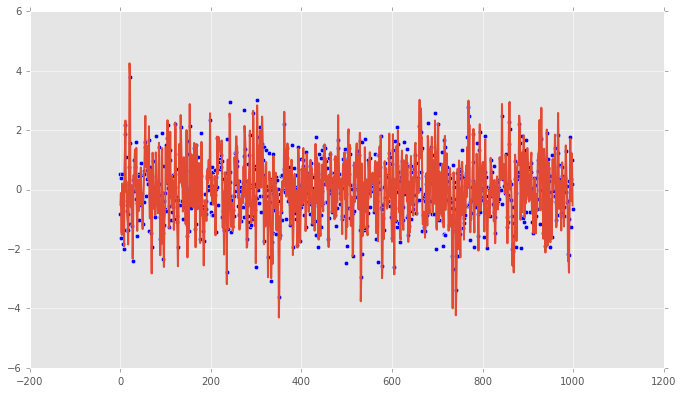

In [16]:
n = 1000
t1 = 0.6

# Set up observed data y
latents = np.random.randn(n+1)
y = MA1(n, t1, latents=latents)

# Plot
plt.figure(figsize=(11, 6));
plt.plot(np.arange(0,n),y);
plt.scatter(np.arange(-1,n), latents);


In [17]:
# Set up the simulator
simulator = partial(MA1, n)

# Set up autocovariance summaries
ac1 = partial(autocov, 1)

# Specify the graphical model
t1 = Prior('t1', 'uniform', 0, 1)
Y = Simulator('MA1', simulator, t1, observed=y)
S1 = Summary('S1', ac1, Y)
d = Discrepancy('d', distance, S1)

# Specify the number of simulations
N = 1000000

# Time and run parallel
s = time.time()
dists = d.generate(N, batch_size=10000).compute()

print("Elapsed time %d sec" % (time.time() - s))

Elapsed time 22 sec


In [20]:
# Set threshold and reject to get posteriors
eps = 1
accepts = dists < eps
t1_post = t1.generate(N).compute()[accepts]
print("Number of accepted samples %d" % sum(accepts))

Number of accepted samples 2509


Posterior for t1


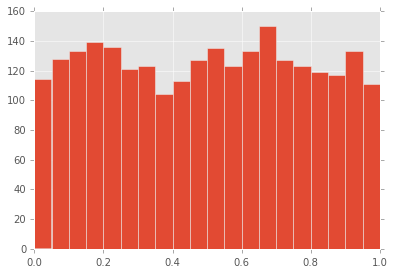

In [21]:
if len(t1_post) > 0:
    print("Posterior for t1")
    plt.hist(t1_post, bins=20)
else:
    print("No accepted samples")